## Libraties and Utilities

In [57]:
from plotly.offline import iplot
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import squarify
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
palette = 'Set2'
sns.set_style('whitegrid')


## Load and check Data

In [14]:
df = pd.read_csv('data.csv', header=0,
                 encoding='unicode_escape',
                 dtype={'CustomerID': str,
                          'InvoiceNo': str},
                 parse_dates=['InvoiceDate'], infer_datetime_format=True)


In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Understanding  Data

### Variable Description

- __InvoiceNo:__ Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- __StockCode:__ Product code that consists 5 digits.
- __Description:__ Product name.
- __Quantity:__ The quantities of each product per transaction.
- __InvoiceDate:__ Represents the day and time when each transaction was generated.
- __UnitPrice:__ Product price per unit.
- __CustomerID:__ Customer number that consists 5 digits. Each customer has a unique customer ID.
- __Country:__ Name of the country where each customer resides.

In [18]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70, '-'))
    print('Row: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))
    print(" QUANTILES ".center(70, '-'))
    print(dataframe.quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_data(df)

------------------------------- SHAPE --------------------------------
Row: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08

In [19]:
def check_data(dataframe, head=5):
    print( " TAIL ".center(70, '-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70, '-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70, '-'))
    print(dataframe.duplicated())
check_data(df)

-------------------------------- TAIL --------------------------------
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID Country  
541904 2011-12-09 12:50:00       0.85      12680  France  
541905 2011-12-09 12:50:00       2.10      12680  France  
541906 2011-12-09 12:50:00       4.15      12680  France  
541907 2011-12-09 12:50:00       4.15      12680  France  
541908 2011-12-09 12:50:00       4.95      12680  France  
--------------------------- MISSING VALUES ---------------------------
InvoiceNo           0
StockCode           0
Description      1454

## Descriptive Statistics

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


There are outliers in Quantity ansd UniPrice that have to bi handled.  
There are negative values in UnitPrice ans Quantity because of cancelled orders. 
Missing values in Decription ans Customer ID.  
Creating Total Price.

## Data Preprocessing

In [21]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):

    # Detect outliers with IQR method:
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile3 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable]) > up_limit, variable] = up_limit

    return df_


def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()

    # Missing values
    df_ = df_.dropna()

    # Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na=False)]
    '''
    Specifying na to be False instead of NaN replaces NaN values with False. 
    If Series or Index does not contain NaN values the resultant dtype will be bool, otherwise, an object dtype.    
    '''
    df_ = df_[df_['Quantity'] > 0]

    # Replacing Outliers
    df_ = replace_with_thresholds(df_, 'Quantity', q1=0.01, q3=0.99)
    df_ = replace_with_thresholds(df_, 'UnitPrice', q1=0.01, q3=0.99)

    # Total Price
    df_['TotalPrice'] = df_['Quantity'] * df_['UnitPrice']

    return df_


In [22]:
df = ecommerce_preprocess(df)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397924.0,11.833736,25.534512,1.0,2.00,6.00,12.00,298.500
UnitPrice,397924.0,2.893163,3.227059,0.0,1.25,1.95,3.75,37.060
TotalPrice,397924.0,20.627751,51.826400,0.0,4.68,11.80,19.80,3268.575


## RFM Analysis

RFM stands for for __Recency, Frequency, Monetary__ value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer's behavior because frequency and monetary value affects a customers's lifetime value, and recency affects retention, a measure, of engagement.  

RFM factors illustrate these facts:  
- The more recent the purchase, the more responsive the customer is to promotions
- The more frecently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders for low - value purchasers

__RFM Metrics__

In [24]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [25]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346,326,1,310.44
12347,3,7,4310.00
12348,76,4,1770.78
12349,19,1,1491.72
12350,311,1,331.46


In [ ]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [45]:
rfm.head()

,level_0,index,CustomerID,Recency,Frequency,Monetary
0,0,0,12346,326,1,310.44
1,1,1,12347,3,7,4310.00
2,2,2,12348,76,4,1770.78
3,3,3,12349,19,1,1491.72
4,4,4,12350,311,1,331.46


In [48]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


__RFM Scores__

In [49]:
def get_rfm_scores(dataframe):
    df_ = dataframe.copy()
    df_['recency_score'] = pd.qcut(df_['Recency'],5, labels=[5, 4, 3, 2, 1])
    df_['frequency_score'] = pd.qcut(df_['Frequency'].rank(method = 'first'), 5, labels =[1, 2, 3, 4, 5])
    df_['monetary_score'] = pd.qcut(df_['Monetary'], 5, labels = [1, 2, 3, 4, 5])
    df_['RFM_SCORE'] = (df_['recency_score'].astype(str) + df_['frequency_score'].astype(str))

    return df_

rfm = get_rfm_scores(rfm)

In [51]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


## Segmentation Map

In [55]:
segments = rfm['segment'].value_counts().sort_values(ascending = False)

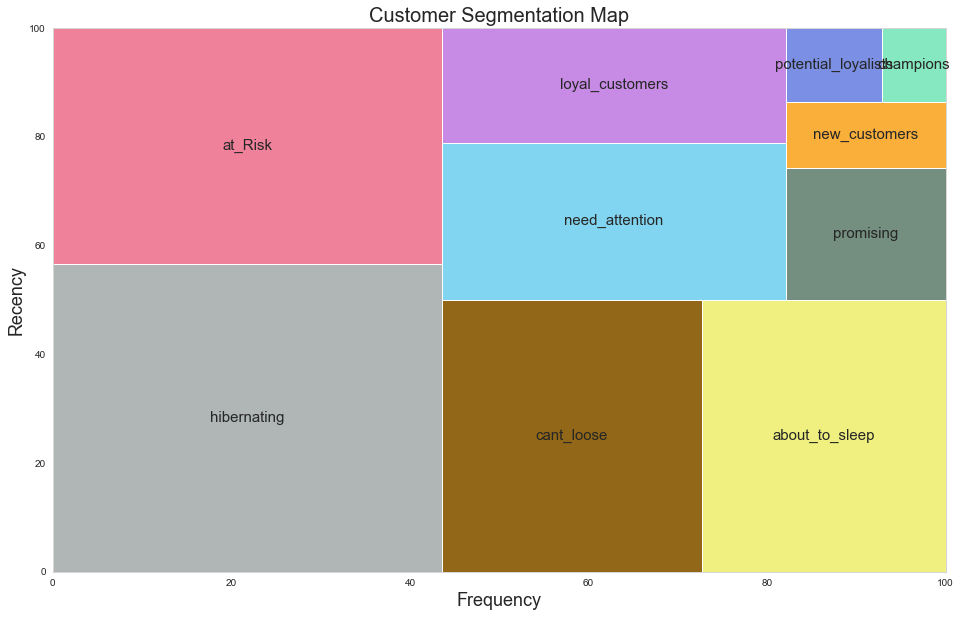

In [63]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes = segments,
            label=[label for label in seg_map.values()],
            color = ['#AFB6B5', '#F0819A', '#926717', '#F0F081', '#81D5F0', '#C78BE5', '#748E80', '#FAAF3A', '#7B8FE4', '#86E8C0'],
            pad = False,
            bar_kwargs = {'alpha': 1},
            text_kwargs = {'fontsize' : 15})
plt.title('Customer Segmentation Map', fontsize = 20)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Recency', fontsize = 18)
plt.show()

## Model Evalution

In [66]:
print(" RFM Model Evaluation ".center(70, '-'))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')

------------------------ RFM Model Evaluation ------------------------
Number of Observations: 4339
Number of Segments: 10


## Segment Analysis

In [69]:
rfm[['Recency', 'Monetary', 'Frequency', 'segment']].groupby('segment').agg({'mean', 'std', 'max', 'min'})

Recency                               Monetary  \
                        max        mean min        std         max   
segment                                                              
about_to_sleep           72   53.312500  34  10.943474    6207.670   
at_Risk                 374  153.785835  73  68.618828   11072.670   
cant_loose              373  132.968254  73  65.250378   10254.180   
champions                13    6.361769   1   3.683300  266163.525   
hibernating             374  217.605042  73  92.013560    9182.345   
loyal_customers          72   33.608059  15  15.577050  120210.355   
need_attention           72   52.427807  34  11.552074    4353.830   
new_customers            13    7.428571   1   3.902112     848.550   
potential_loyalists      33   17.398760   1   9.338808    4628.750   
promising                33   23.421053  15   5.238115    1491.720   

                                                       Frequency             \
                            mean     min           std       max       mean   
segment                                                                       
about_to_sleep        469.058097    6.20    533.161343         2   1.161932   
at_Risk               938.458341   52.00    943.170824         6   2.878583   
cant_loose           2646.822540   70.02   2008.352354        34   8.380952   
champions            6498.612978  198.23  18366.105822       210  12.417062   
hibernating           398.573036    3.75    553.714975         2   1.101774   
loyal_customers      2752.519574   36.56   5405.787839        63   6.479853   
need_attention        847.657086    6.90    732.298552         3   2.326203   
new_customers         314.883690   89.94    174.620952         1   1.000000   
potential_loyalists   674.628357   20.80    601.746293         3   2.010331   
promising             282.617158    0.00    224.363976         1   1.000000   

                                    
                    min        std  
segment                             
about_to_sleep        1   0.368913  
at_Risk               2   0.954415  
cant_loose            6   4.289630  
champions             3  16.476484  
hibernating           1   0.302492  
loyal_customers       3   4.545669  
need_attention        2   0.470081  
new_customers         1   0.000000  
potential_loyalists   1   0.651401  
promising             1   0.000000

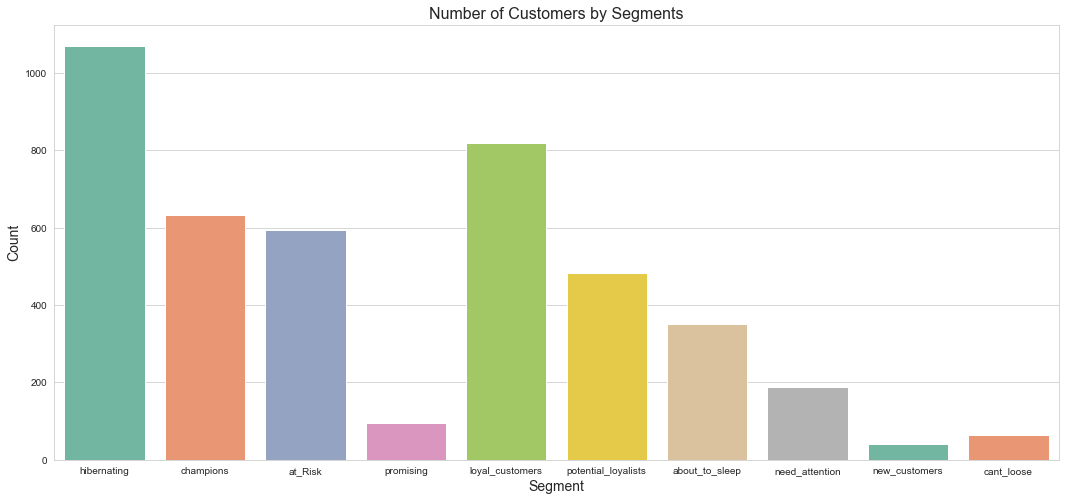

In [71]:
plt.figure(figsize= (18, 8))
ax = sns.countplot(data = rfm, x='segment', palette = palette)
plt.xlabel('Segment', size=14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title('Number of Customers by Segments', size = 16)
total = len(rfm.segment)
plt.show()

## Recency & Frequency by Segments

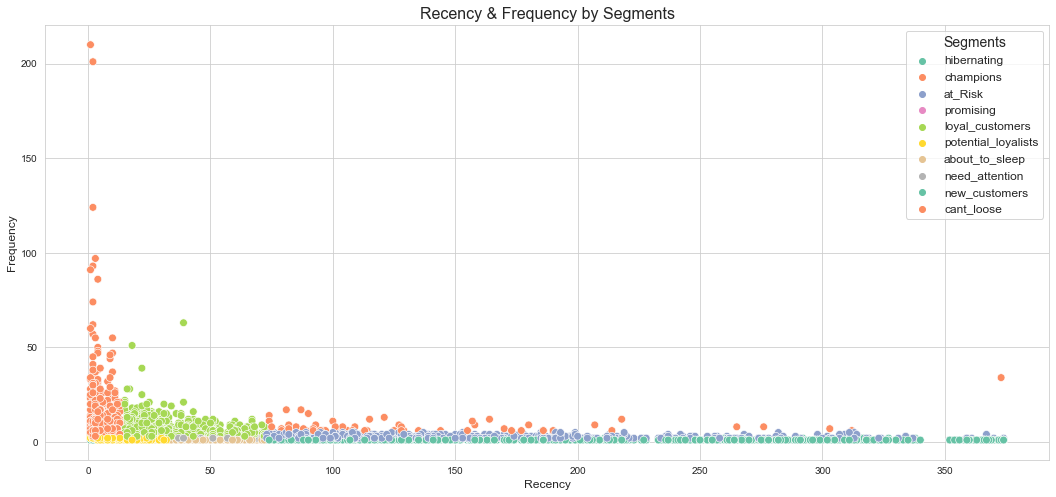

In [72]:
plt.figure(figsize= (18, 8))
sns.scatterplot(data = rfm, x = 'Recency', y = 'Frequency', hue = 'segment', palette=palette, s = 60)
plt.title('Recency & Frequency by Segments', size = 16)
plt.xlabel('Recency', size = 12)
plt.ylabel('Frequency', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.legend(loc ='best', fontsize = 12, title = 'Segments', title_fontsize = 14)
plt.show()